<a href="https://colab.research.google.com/github/Vrroom/notebooks/blob/main/Zero_Shot_CLIP_on_TU_Berlin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP on Sketches

In [ ]:
# Setup 
!nvidia-smi
!git clone https://github.com/openai/CLIP
!pip install -e ./CLIP
!git clone https://github.com/Vrroom/vectorrvnn
!pip install setuptools-rust
!apt install rustc
import os
os.chdir('vectorrvnn')
!python3 setup.py install --user
os.chdir('../')
!rm -r vectorrvnn
!wget http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_svg.zip
!unzip sketches_svg.zip

You have to restart the kernel after the setup in order to use modules on Colab. It is what it is ⌛

Total graphics - 20000


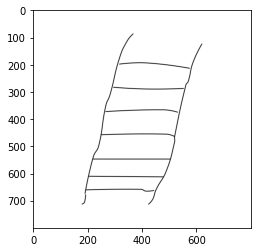

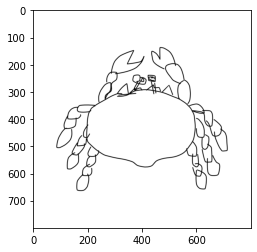

In [1]:
import svgpathtools
from vectorrvnn.utils import *
import matplotlib.pyplot as plt
import random

svgs = [_ for _ in allfiles('./svg') if _.endswith('svg')]
print('Total graphics -', len(svgs))
sample = random.sample(svgs, k=2)

for s in sample : 
  doc = svg.Document(s)
  plt.imshow(rasterize(doc))
  plt.show()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 122MiB/s]


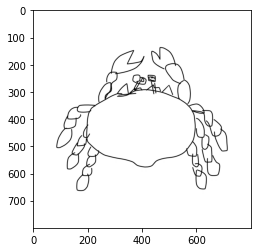

Label probs: [[9.990e-01 6.771e-04 8.744e-05 1.222e-05 3.648e-05]]


In [2]:
# Try out CLIP 
import torch
import sys
sys.path.append('./CLIP')
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

im = alphaComposite(rasterize(doc))
im = Image.fromarray((255 * im).astype(np.uint8))
plt.imshow(im)
plt.show()
image = preprocess(im).unsqueeze(0).to(device)
text = clip.tokenize(["a crab", "Icecream Softie", "an ambulance", "The great wall of China", "An amazing satellite"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)

100%|██████████| 252/252 [26:10<00:00,  6.23s/it]


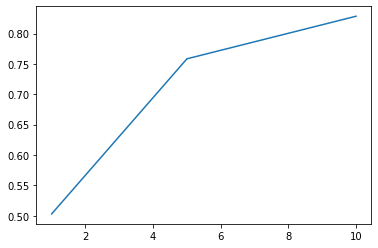

In [3]:
# Measure Top-5 Accuracy
import os
import os.path as osp
from tqdm import tqdm

def svg2im (svgFile) : 
  doc = svg.Document(svgFile)
  im = alphaComposite(rasterize(doc))
  im = Image.fromarray((255 * im).astype(np.uint8))
  return im

labels = [getBaseName(_) for _ in listdir('svg')]
labelIdMap = serialMapping(labels)

labels = clip.tokenize(labels).to(device)
KS = [1, 5, 10]
topK, total = [0, 0, 0], 0

with torch.no_grad() : 
  text_features = model.encode_text(labels)
  text_features = text_features / text_features.norm(dim=1, keepdim=True)

for dir in tqdm(listdir('svg')) : 
  labelId = labelIdMap[getBaseName(dir)]
  try: 
    vectors = listdir(dir)
  except Exception : continue
  rasters = [svg2im(_) for _ in vectors]
  # preprocess images in a batch
  image = []
  for raster in rasters: 
    image.append(preprocess(raster).unsqueeze(0).to(device))
  image = torch.cat(image)
  # compute logits
  with torch.no_grad() : 
    image_features = model.encode_image(image)
    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    # cosine similarity as logits
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()

  for logits in logits_per_image : 
    probs = logits.softmax(dim=-1).view(-1).cpu().numpy()
    for i, k in enumerate(KS) : 
      top = set(np.argsort(probs).tolist()[-k:])
      if labelId in top :
        topK[i] += 1
    total += 1

topK = [_ / total for _ in topK]
plt.plot([1, 5, 10], topK)
